<a href="https://colab.research.google.com/github/drSever/Flame/blob/master/h_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Детекция лесных пожаров. Задача бинарной классификации по фото.

## Набор данных для решения задачи: FLAME, который содержит аэроснимки с дронов для задач классификации, связанных с обнаружением огненных очагов.

![Текст ссылки](https://ieee-dataport.org/sites/default/files/styles/large/public/dataset_intro.jpg?itok=ZMenAr5c)

Лесные пожары - одно из самых смертоносных и опасных стихийных бедствий в мире. Лесные пожары сжигают миллионы лесов и подвергают опасности жизни людей и животных. Прогнозирование поведения пожара может помочь пожарным лучше управлять огнем и планировать будущие инциденты, а также снизить риск для жизни пожарных. Последние достижения в области аэрофотосъемки показывают, что они могут быть полезны при изучении лесных пожаров. Среди различных методов и технологий получения аэрофотоснимков, беспилотные летательные аппараты (БПЛА) и дроны являются полезными для сбора информации о пожаре. В данном исследовании представлен набор данных FLAME (Fire Luminosity Airborne-based Machine Learning Evaluation), полученных с помощью беспилотников во время предписанного сжигания куч в Северной Аризоне, США. 

Ссылка на датасет:    
https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs

Опубликованная статья доступна здесь:    
https://www.sciencedirect.com/science/article/pii/S1389128621001201

Препринт статьи об этом наборе данных доступен здесь:    
https://arxiv.org/pdf/2012.14036.pdf

Более подробную информацию об этом исследовании и двух задачах машинного обучения, которые использовались, можно найти здесь:    
https://github.com/AlirezaShamsoshoara/Fire-Detection-UAV-Aerial-Image-Classification-Segmentation-UnmannedAerialVehicle

# Установка и импорт библиотек

## Установка библиотек

Для предотвращения ошибки:       
`AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'`

In [1]:
%%capture
!pip install tensorflow[and-cuda]==2.14.0

Для просмотра дерева каталогов

In [2]:
%%capture
!apt-get install tree

## Импорт библиотек

In [2]:
from google.colab import drive
from numba import cuda
from zipfile import ZipFile
import tree
import pickle
import os
import os.path

from tqdm import tqdm
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model

# Загрузка и подготовка данных

In [3]:
# подключаем Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# прописываем пути к исходным данным

# путь к архиву с данными
PATH_TO_ZIP = "/content/gdrive/MyDrive/Colab_Notebooks/h_project/dataset.zip"
# путь к распакованному датасету
PATH_TO_DATASET = "frames"

In [5]:
# распаковка данных

# открываем .zip файл
with ZipFile(file=PATH_TO_ZIP) as zip_file:

    # проходимся по каждому файлу
    for file in tqdm(iterable=zip_file.namelist(), total=len(zip_file.namelist())):
        zip_file.extract(member=file, path=PATH_TO_DATASET)

100%|██████████| 96000/96000 [00:38<00:00, 2485.84it/s]


In [6]:
# удаляем лишнюю папку (какой-то баг из-за MacOS на моем ноуте)
!rm -rf /content/frames/__MACOSX

# Обучение модели

Архитектура сети:

![Текст ссылки](https://ars.els-cdn.com/content/image/1-s2.0-S1389128621001201-gr3.jpg)

Основа модели - модель реализована на основе [руководства](https://keras.io/examples/vision/image_classification_from_scratch/) в Keras (сеть Xception).

В датасете цветные изображения размером 254х254.

2 класса: **0** - пожар (*Fire*), **1** - нет пожара (*No_Fire*)

Тренировочные данные (*/Training*) разбиваются на собственно тренировочную и валидационную выборки.

Инференс проводится на тестовой выборке (*/Test*), модель при обучении не видит тестовую выборку.

## Знакомство с данными

In [8]:
# выведем структуру датасета
ROOT = PATH_TO_DATASET
!ls {ROOT}
!tree -d {ROOT}

Test  Training
frames
├── Test
│   ├── Fire
│   └── No_Fire
└── Training
    ├── Fire
    └── No_Fire

6 directories


In [9]:
# выведем количество изображений датасета
FOLDER_PATH = '/content/' + PATH_TO_DATASET + '/Training/Fire'
print(FOLDER_PATH, len(os.listdir(os.path.join(FOLDER_PATH))))
FOLDER_PATH = '/content/' + PATH_TO_DATASET + '/Training/No_Fire'
print(FOLDER_PATH, len(os.listdir(os.path.join(FOLDER_PATH))))
FOLDER_PATH = '/content/' + PATH_TO_DATASET + '/Test/Fire'
print(FOLDER_PATH, len(os.listdir(os.path.join(FOLDER_PATH))))
FOLDER_PATH = '/content/' + PATH_TO_DATASET + '/Test/No_Fire'
print(FOLDER_PATH, len(os.listdir(os.path.join(FOLDER_PATH))))

/content/frames/Training/Fire 25018
/content/frames/Training/No_Fire 14357
/content/frames/Test/Fire 5137
/content/frames/Test/No_Fire 3480


## Настройки обучения модели

In [7]:
# выбираем метрику для METRIC_TRAINING
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.BinaryAccuracy(name='bin_accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]

# размер входного изображения
new_size = {'width': 256, 'height': 256}
IMAGE_SIZE = (new_size.get('width'), new_size.get('height'))

BATCH_SIZE = 32
#BATCH_SIZE = 4096 # для 83.5Гб ОЗУ и 40ГБ GPU - соответствует A100
#BATCH_SIZE = 2048 # для 53Гб ОЗУ и 22.5ГБ GPU - соответствует L4
SAVE_MODEL_FLAG = True # сохранение обученной модели
EPOCHS = 40 # количество эпох обучения
TRAINING_PLOT = True # сохранение диаграмм с результатами обучения

# выбор метрик для обучения и вывода на графике
METRIC_TRAINING = keras.metrics.BinaryAccuracy(name='bin_accuracy')
METRIC_PLOT = 'bin_accuracy'
METRIC_PLOT_LABEL = 'Bin Accuracy'

# путь к сохранению выходных данных на Google Drive
GDRIVE_PATH = '/content/gdrive/MyDrive/Colab_Notebooks/h_project/'

# настройки сохранения выходных данных
PATH_TO_OUTPUT_FigureObject = GDRIVE_PATH + 'Output/FigureObject' # путь для сохранения результатов обучения
PATH_TO_OUTPUT_Figures = GDRIVE_PATH + 'Output/Figures' # путь для сохранения результатов обучения (pdf)
PATH_TO_ModelCheckpoint = GDRIVE_PATH + 'Output/ModelCheckpoint' # путь для сохранения чекпоинтов модели
PATH_TO_MODEL = GDRIVE_PATH + 'Output/Model' # путь для сохранения обученной модели
# создаем указанные пути для сохранения данных
os.makedirs(PATH_TO_OUTPUT_FigureObject, exist_ok=True)
os.makedirs(PATH_TO_OUTPUT_Figures, exist_ok=True)
os.makedirs(PATH_TO_ModelCheckpoint, exist_ok=True)
os.makedirs(PATH_TO_MODEL, exist_ok=True)

## Знакомство с данными

In [11]:
# тренировочный датасет
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TO_DATASET + "/Training",  seed=1337, image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, shuffle=True
)
# тестовый датасет
ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TO_DATASET + "/Test",  seed=1337, image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, shuffle=True
)

Found 39375 files belonging to 2 classes.
Found 8617 files belonging to 2 classes.


In [12]:
# аугментации
data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )

In [23]:
def dataset_plot(dataset, augmented=False):
    """
    Функция принимает датасет и необходимость аугментации и выводит изображения
    датасета с метками классов.
    dataset: датасет
    augmented: необходимость аугментации изображений (по умолчанию False)
    return: None
    """
    # задаем фигуру
    plt.figure(figsize=(10, 10))
    # получаем картинки и метки датасета
    for images, labels in dataset.take(1):
        for i in range(9):
            # выводим изображения с метками
            # если нужна аугментация
            if augmented:
              images = data_augmentation(images)
            _ = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")

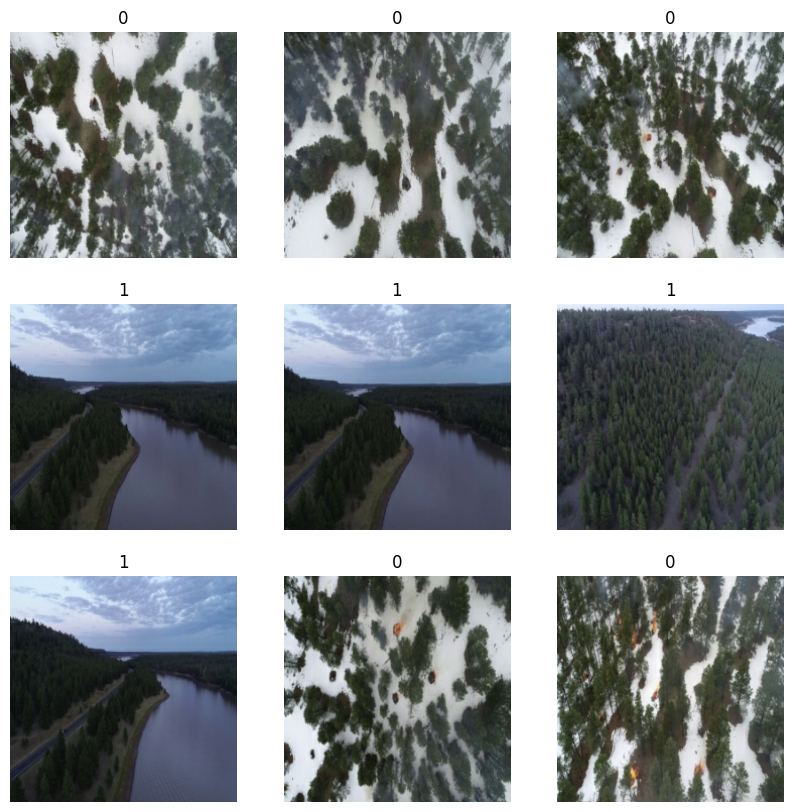

In [24]:
# 9 изображений из тренировочного датасета с метками (0 - пожар, 1 - нет пожара)
dataset_plot(ds_train)

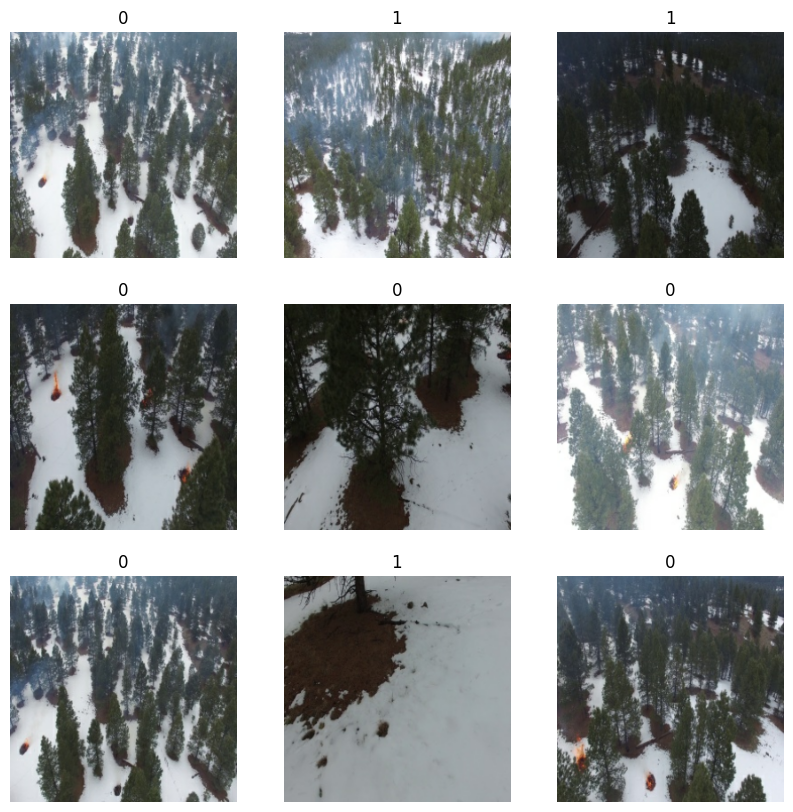

In [25]:
# 9 изображений из тестового датасета с метками (0 - пожар, 1 - нет пожара)
dataset_plot(ds_test)

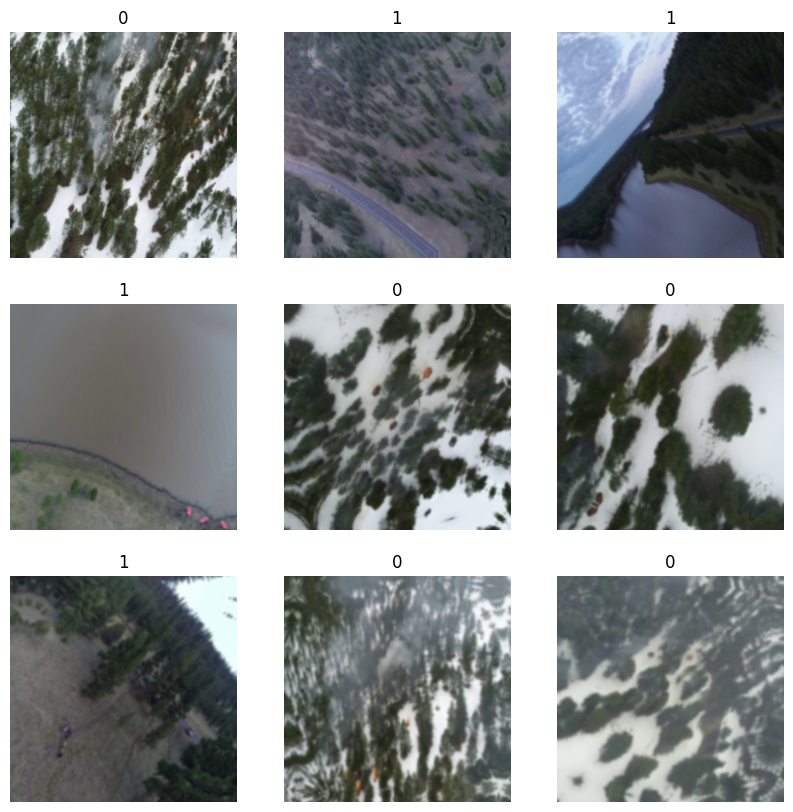

In [27]:
# 9 аугментированных изображений тренировочного датасета
dataset_plot(ds_train, augmented=True)

## Обучение модели

In [20]:
def make_model_keras(input_shape, num_classes):
    """
    Эта функция определяет модель DNN на основе примера Keras:
    https://keras.io/examples/vision/image_classification_from_scratch/
    :param input_shape: требуемый размер изображения
    :param num_classes: В этой задаче классификации есть два класса: 1) пожар Fire и 2) не пожар Non_Fire.
    :return: возвращается модель
    """
    inputs = keras.Input(shape=input_shape)
    # x = data_augmentation(inputs)  # 1) First option
    x = inputs  # 2) Second option

    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    # x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.Conv2D(8, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    # for size in [128, 256, 512, 728]:
    for size in [8]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)

        x = layers.add([x, residual])
        previous_block_activation = x
    x = layers.SeparableConv2D(8, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs, name="model_fire")

In [21]:
# для вывода Loss и метрики
def plot_training(result, type_model, layers_len):
    """
    Функция выводит результат обучения модели: значения Loss-функции,
    значения метрики, сохраняет диаграммы.
    """
    # глобальные переменные

    # метрика
    global METRIC_PLOT # метрика
    global METRIC_PLOT_LABEL # подпись на диаграмме
    # настройки сохранения выходных данных
    global PATH_TO_OUTPUT_FigureObject
    global PATH_TO_OUTPUT_Figures

    # выводим диаграммы с метриками

    (fig, ax) = plt.subplots(2, 1, figsize=(13, 13))
    epochs = len(result.history[METRIC_PLOT])

    # диаграмма LOSS-функции
    ax[0].set_title("Loss", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Epoch #", fontsize=14, fontweight="bold")
    ax[0].set_ylabel("Loss", fontsize=14, fontweight="bold")
    ax[0].plot(np.arange(1, epochs+1), result.history['loss'], label='Loss', linewidth=2.5, linestyle='-', marker='o',
               markersize='10', color='red')
    ax[0].plot(np.arange(1, epochs+1), result.history['val_loss'], label='Validation_loss', linewidth=2.5, marker='x',
               linestyle='--', markersize='10', color='blue')
    ax[0].grid(True)
    ax[0].legend(prop={'size': 14, 'weight': 'bold'})
    ax[0].tick_params(axis='both', which='major', labelsize=15)

    plt.subplots_adjust(hspace=0.3)

    # диаграмма метрики
    ax[1].set_title(METRIC_PLOT_LABEL, fontsize=14, fontweight="bold")
    ax[1].set_xlabel("Epoch #", fontsize=14, fontweight="bold")
    ax[1].set_ylabel(METRIC_PLOT_LABEL, fontsize=14, fontweight="bold")
    ax[1].plot(np.arange(1, epochs+1), result.history[METRIC_PLOT], label=METRIC_PLOT_LABEL, linewidth=2.5, linestyle='-',
               marker='o', markersize='10', color='red')
    ax[1].plot(np.arange(1, epochs+1), result.history['val_' + METRIC_PLOT], label='Validation_' + METRIC_PLOT_LABEL, linewidth=2.5,
               linestyle='--', marker='x', markersize='10', color='blue')
    ax[1].grid(True)
    ax[1].legend(prop={'size': 14, 'weight': 'bold'}, loc='best')
    ax[1].tick_params(axis='both', which='major', labelsize=15)

    # сохраняем полученные данные
    file_figobj = PATH_TO_OUTPUT_FigureObject + '/%s_%d_EPOCH_%d_layers_opt.fig.pickle' % (type_model, epochs, layers_len)
    file_pdf = PATH_TO_OUTPUT_Figures + '/%s_%d_EPOCH_%d_layers_opt.pdf' % (type_model, epochs, layers_len)
    pickle.dump(fig, open(file_figobj, 'wb'))
    fig.savefig(file_pdf, bbox_inches='tight')

In [26]:
def train_keras():
    """
    Эта функция обучает DNN-модель на основе Keras и Tensorflow в качестве бэкенда.
    Сохраняет модель в виде весов после каждой эпохи. В конце обучения сохраняет обученную модель,
    выводит и сохраняет данные Loss-функции и метрики.
    :params: None
    :return: None
    """

    # глобальные переменные

    global PATH_TO_DATASET # путь к датасету
    global PATH_TO_MODEL # путь к сохранению обученной модели
    global BATCH_SIZE # размер батча
    global EPOCHS # количество эпох
    global METRIC_TRAINING # метрика
    global IMAGE_SIZE # требуемый размер изображения
    global SAVE_MODEL_FLAG # сохранять обученную модель (True/False)
    global TRAINING_PLOT # выводить диаграмму с результатами обучения (True/False)

    # Эта модель реализована на основе руководства в Keras (сеть Xception).
    # https://keras.io/examples/vision/image_classification_from_scratch/
    print(" --------- Training --------- ")

    dir_fire = PATH_TO_DATASET + '/Training/Fire/'
    dir_no_fire = PATH_TO_DATASET + '/Training/No_Fire/'

    # 0 is Fire and 1 is NO_Fire
    fire = len([name for name in os.listdir(dir_fire) if os.path.isfile(os.path.join(dir_fire, name))])
    no_fire = len([name for name in os.listdir(dir_no_fire) if os.path.isfile(os.path.join(dir_no_fire, name))])
    total = fire + no_fire
    weight_for_fire = (1 / fire) * total / 2.0
    weight_for_no_fire = (1 / no_fire) * total / 2.0
    # class_weight = {0: weight_for_fire, 1: weight_for_no_fire}

    print("Weight for class fire : {:.2f}".format(weight_for_fire))
    print("Weight for class No_fire : {:.2f}".format(weight_for_no_fire))


    # тренировочный датасет
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        PATH_TO_DATASET + "/Training", validation_split=0.2, subset="training", seed=1337, image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE, shuffle=True
    )
    # валидационный датасет
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        PATH_TO_DATASET + "/Training", validation_split=0.2, subset="validation", seed=1337, image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE, shuffle=True
    )

    train_ds = train_ds.prefetch(buffer_size=32)
    val_ds = val_ds.prefetch(buffer_size=32)

    model = make_model_keras(input_shape=IMAGE_SIZE + (3,), num_classes=2)
    keras.utils.plot_model(model, show_shapes=True)

    callbacks = [keras.callbacks.ModelCheckpoint(PATH_TO_ModelCheckpoint + "/save_at_{epoch}.h5"), ]
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=METRIC_TRAINING, )
    res_fire = model.fit(train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds, batch_size=BATCH_SIZE)

    layers_len = len(model.layers)

    if SAVE_MODEL_FLAG:
        file_model_fire = PATH_TO_MODEL + '/model_fire'
        model.save(file_model_fire)
    if TRAINING_PLOT:
        plot_training(res_fire, 'KerasModel', layers_len)

 --------- Training --------- 
Weight for class fire : 0.79
Weight for class No_fire : 1.37
Found 39375 files belonging to 2 classes.
Using 31500 files for training.
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.
Epoch 1/40
985/985 [==============================] - 24s 19ms/step - loss: 0.3030 - bin_accuracy: 0.8758 - val_loss: 0.1728 - val_bin_accuracy: 0.9394
Epoch 2/40
  1/985 [..............................] - ETA: 1:19 - loss: 0.1690 - bin_accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


985/985 [==============================] - 18s 18ms/step - loss: 0.2205 - bin_accuracy: 0.9111 - val_loss: 0.2992 - val_bin_accuracy: 0.9074
Epoch 3/40
985/985 [==============================] - 18s 18ms/step - loss: 0.2027 - bin_accuracy: 0.9164 - val_loss: 0.2310 - val_bin_accuracy: 0.9360
Epoch 4/40
985/985 [==============================] - 18s 18ms/step - loss: 0.1895 - bin_accuracy: 0.9210 - val_loss: 0.2656 - val_bin_accuracy: 0.9318
Epoch 5/40
985/985 [==============================] - 18s 18ms/step - loss: 0.1792 - bin_accuracy: 0.9256 - val_loss: 0.1153 - val_bin_accuracy: 0.9440
Epoch 6/40
985/985 [==============================] - 18s 18ms/step - loss: 0.1707 - bin_accuracy: 0.9270 - val_loss: 0.1739 - val_bin_accuracy: 0.9514
Epoch 7/40
985/985 [==============================] - 18s 18ms/step - loss: 0.1628 - bin_accuracy: 0.9299 - val_loss: 0.0998 - val_bin_accuracy: 0.9581
Epoch 8/40
985/985 [==============================] - 18s 18ms/step - loss: 0.1527 - bin_accuracy: 

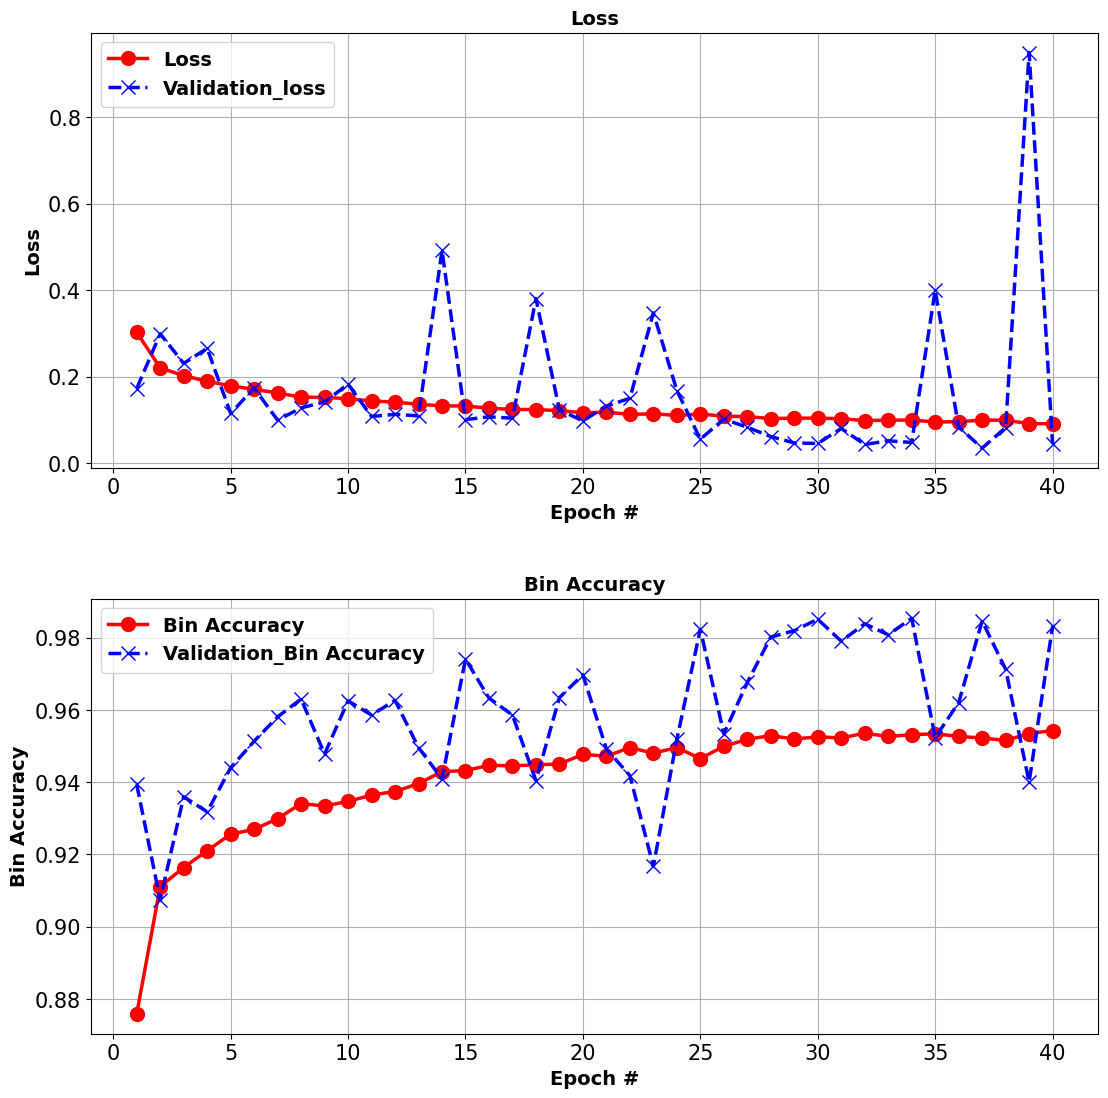

In [27]:
# обучаем модель
%%time
train_keras()

In [ ]:
# очищаем память GPU после обучения (экономим деньги)
device = cuda.get_current_device()
device.reset()

***
***

# Инференс

In [28]:
# убираем предупреждения
import warnings
warnings.filterwarnings("ignore")

## Загружаем нужный чекпоинт

In [19]:
# путь к нужному чекпоинту
PATH_TO_ModelCheckpoint = '/content/gdrive/MyDrive/Colab_Notebooks/h_project/Output_L4_BS_32_best37_best/ModelCheckpoint/save_at_37.h5'
# получение модели из чекпоинта
model = load_model(PATH_TO_ModelCheckpoint)

In [ ]:
#model.summary()

## Инференс на случайном изображении

1/1 [==============================] - 2s 2s/step

This image is 98.38 percent Fire and 1.62 percent No Fire.



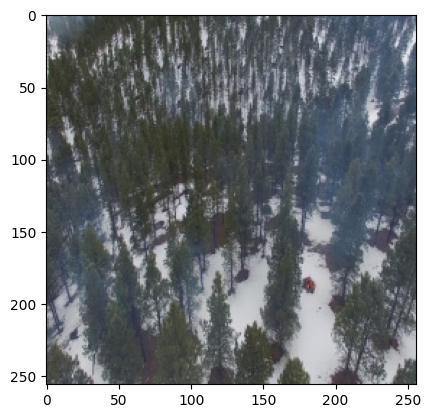

In [30]:
# задаем случайное изображение
random_file = random.choice(os.listdir(PATH_TO_DATASET + "/Test/Fire/"))
# загружаем и выводим случайное изображение
img = keras.preprocessing.image.load_img(
    PATH_TO_DATASET + "/Test/Fire/"+ random_file, target_size=IMAGE_SIZE)
plt.imshow(img)

# преобразуем случайное изображение
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# подвем на вход в модель и получаем предсказание
predictions = model.predict(img_array)

# получаем вероятность класса 1 (нет пожара)
score = predictions[0]
print("\nThis image is %.2f percent Fire and %.2f percent No Fire.\n" % (100 * (1 - score), 100 * score))

In [52]:
def visualize_predictions_test(model, test):
    """
    Функция принимает на вход модель и класс тестовой выборки (Fire и No_Fire),
    выводит 9 случайных изображений из выборки и указывает верятность их принадлежности к
    классам. Выводит количество и долю правильно угаданных изображений.
    model: модель
    test (str): выборка пожар (Fire) или нет пожара (No_Fire)
    """
    # путь к датасету
    global PATH_TO_DATASET

    # задаем фигуру
    plt.figure(figsize=(16,16))
    true_count = 0
    for i in range(9):

        # если тестируем на выборке класса 0 - пожар
        if test == "Fire":
            random_file = random.choice(os.listdir(PATH_TO_DATASET + "/Test/Fire/"))
            path_dir = PATH_TO_DATASET + "/Test/Fire/"
        # если тестируем на выборке класса 1 - нет пожара
        elif test == "No_Fire":
            random_file = random.choice(os.listdir(PATH_TO_DATASET + "/Test/No_Fire/"))
            path_dir = PATH_TO_DATASET + "/Test/No_Fire/"

        # загружаем случайное изображение
        img = keras.preprocessing.image.load_img(
            path_dir + random_file, target_size=IMAGE_SIZE)
        # преобразуем изображение
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        # подаем его в модель и получаем предсказание
        predictions = model.predict(img_array)
        score = predictions[0][0]
        # расчитываем вероятности принадлежности к классам в %
        prob_fire = np.round((100 * (1 - score)), 2)
        prob_no_fire = np.round((100 * score), 2)

        # расчитываем кол-во правильно угаданных изображений

        # если тестируем на выборке класса 0 - пожар
        if test == "Fire":
            if prob_fire > 50:
              true_count += 1
        # если тестируем на выборке класса 1 - нет пожара
        elif test == "No_Fire":
            if prob_no_fire > 50:
              true_count += 1

        # выводим искомые данные

        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.xlabel(f"{prob_fire} % Fire  /  {prob_no_fire} % No Fire.", fontsize=10)
        plt.xticks([])
        plt.yticks([])
    plt.show()

    print(f"Правильно предсказано в {true_count} случаях из 9 ({np.round((true_count/9) * 100)} %)")


## Проверяем на тестовой выборке, класс 0 - Fire (пожар)

1/1 [==============================] - 0s 28ms/step


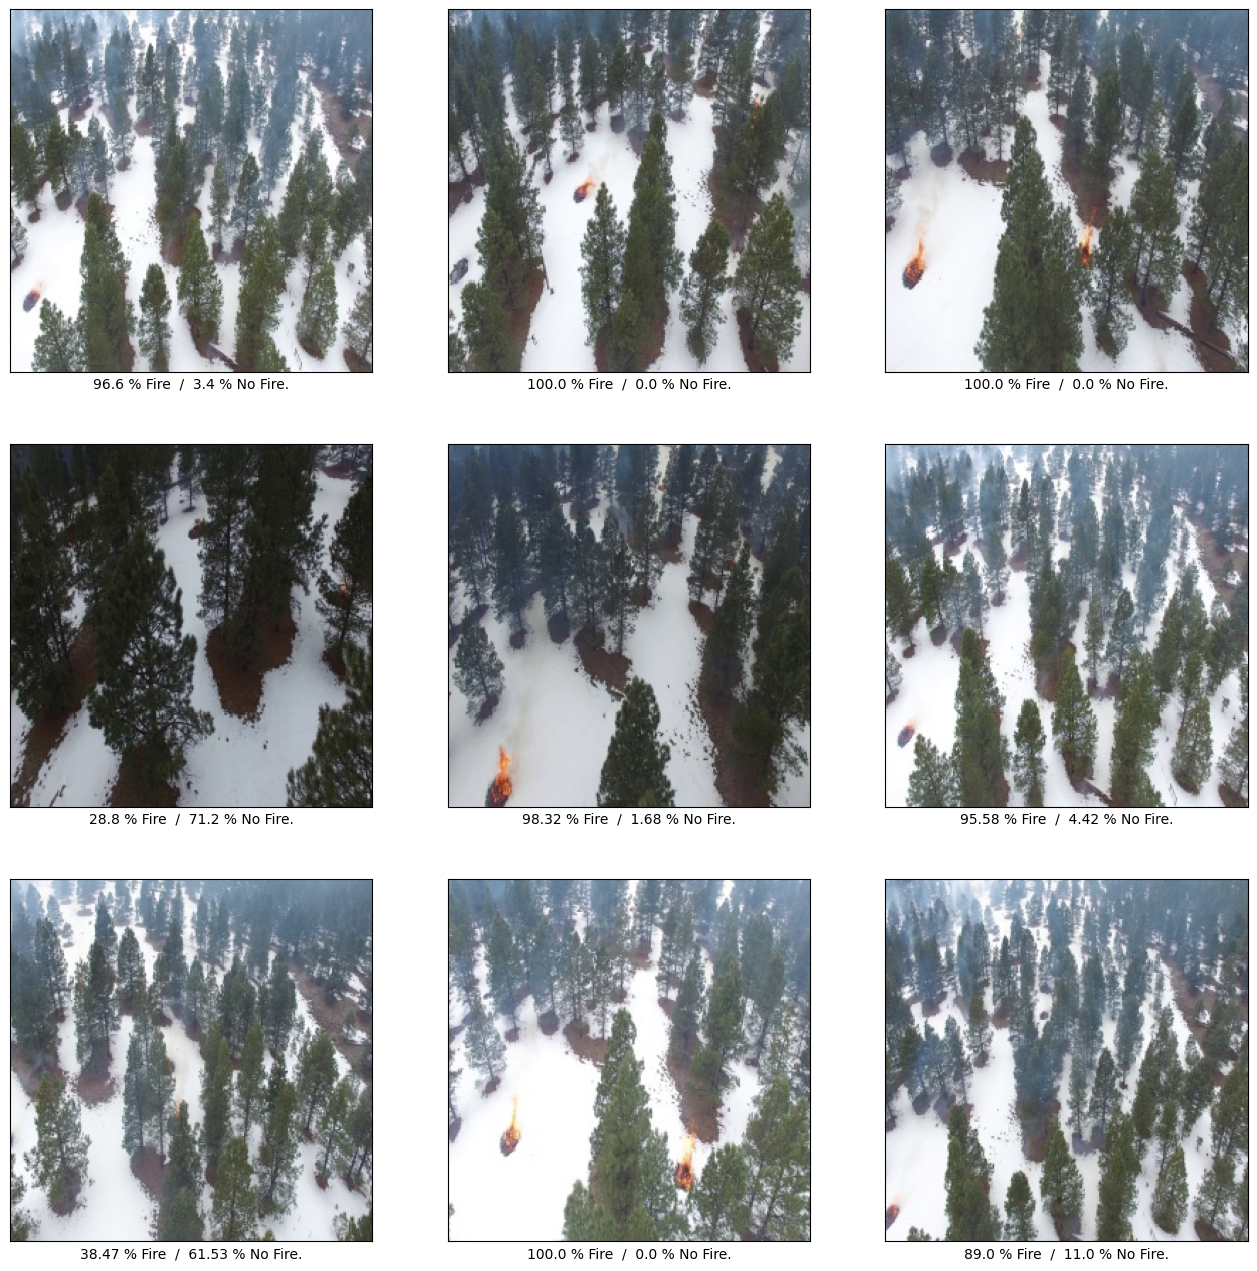

Правильно предсказано в 7 случаях из 9 (78.0 %)


In [53]:
visualize_predictions_test(model, test="Fire")

## Проверяем на тестовой выборке, класс 1 - No_Fire (нет пожара)

1/1 [==============================] - 0s 33ms/step


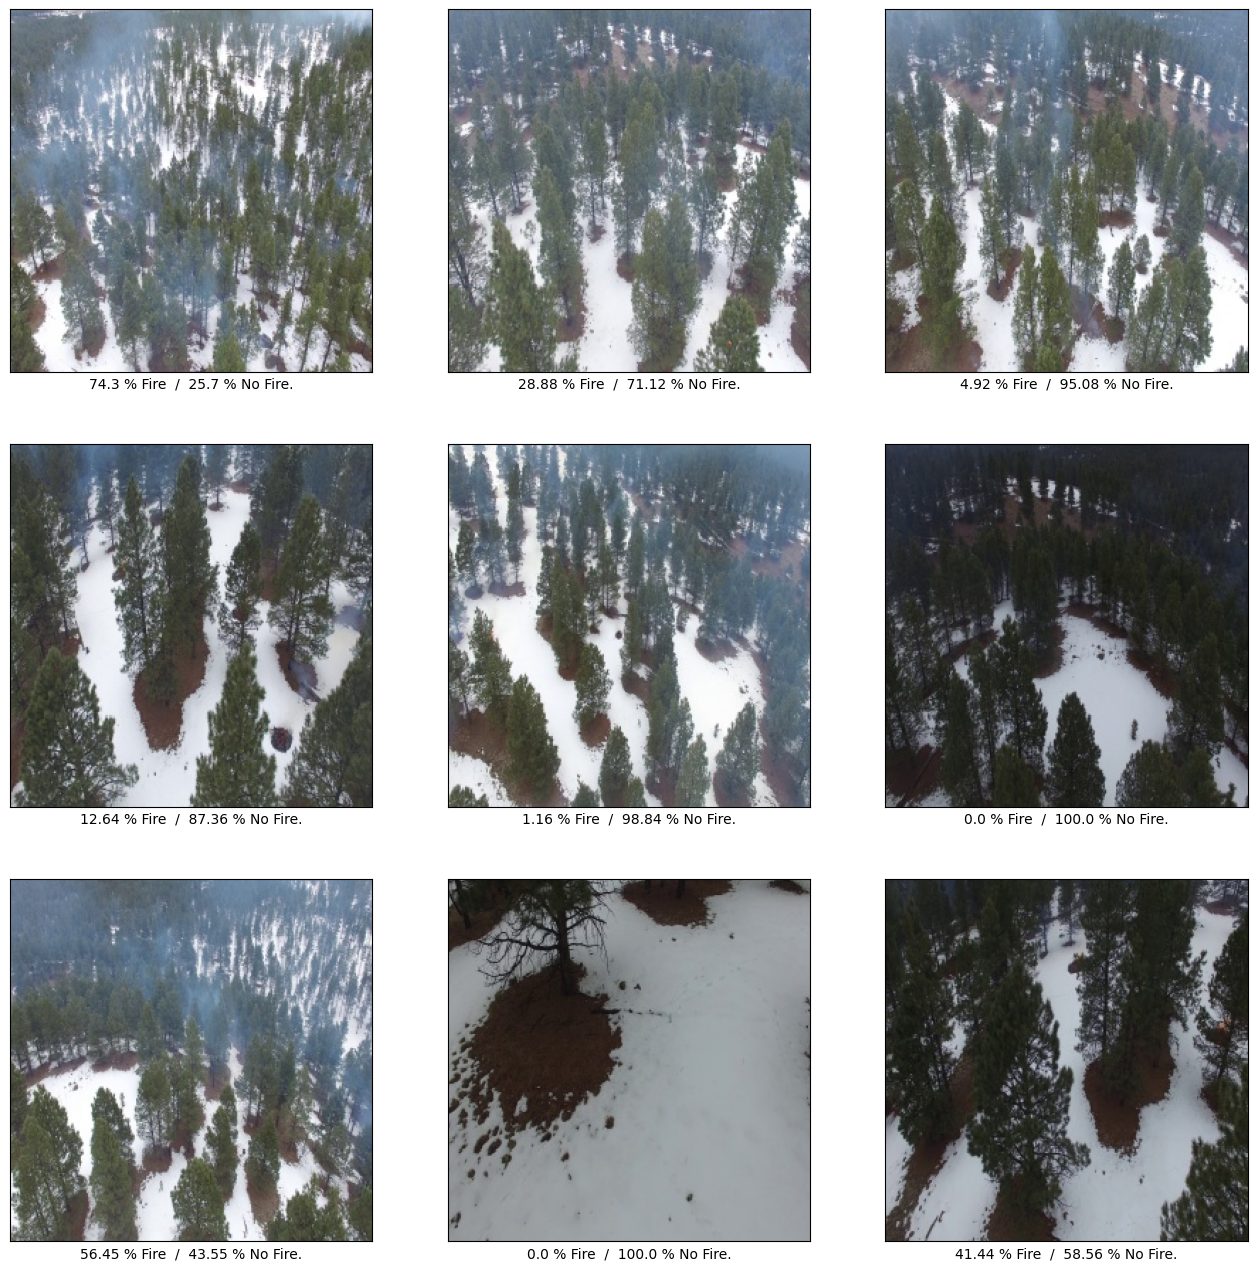

Правильно предсказано в 7 случаях из 9 (78.0 %)


In [54]:
visualize_predictions_test(model, test="No_Fire")

## Выберем по 100 случайных изображений каждого класса и расчитаем % правильного предсказания

In [77]:
%%capture
# класс 0 - пожар

# выберем 100 случайных файлов выборки
files = os.listdir(PATH_TO_DATASET + "/Test/Fire/")
random_files = random.sample(files, 100)


true_count = 0
for file in random_files:
  # загружаем изображение
  img = keras.preprocessing.image.load_img(
      PATH_TO_DATASET + "/Test/Fire/" + file, target_size=IMAGE_SIZE)
  # преобразуем изображение
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  # подаем его в модель и получаем предсказание
  predictions = model.predict(img_array)
  score = predictions[0][0]
  # расчитываем вероятности принадлежности к классам в %
  prob_fire = np.round((100 * (1 - score)), 2)
  prob_no_fire = np.round((100 * score), 2)

  if prob_fire > 50:
    true_count += 1

In [79]:
print(f"Модель правильно предсказывает в {(true_count/100)*100} % случаев" )

Модель правильно предсказывает в 71.0 % случаев


In [88]:
%%capture
# класс 1 - пожара нет

# выберем 100 случайных файлов выборки
files = os.listdir(PATH_TO_DATASET + "/Test/No_Fire/")
random_files = random.sample(files, 100)


true_count = 0
for file in random_files:
  # загружаем изображение
  img = keras.preprocessing.image.load_img(
      PATH_TO_DATASET + "/Test/No_Fire/" + file, target_size=IMAGE_SIZE)
  # преобразуем изображение
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  # подаем его в модель и получаем предсказание
  predictions = model.predict(img_array)
  score = predictions[0][0]
  # расчитываем вероятности принадлежности к классам в %
  prob_fire = np.round((100 * (1 - score)), 2)
  prob_no_fire = np.round((100 * score), 2)

  if prob_no_fire > 50:
    true_count += 1

In [89]:
print(f"Модель правильно предсказывает в {(true_count/100)*100} % случаев" )

Модель правильно предсказывает в 89.0 % случаев


# Сохраняем модель

In [91]:
# keras модель
model.save(GDRIVE_PATH + "/model")

In [20]:
# tflite модель
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
file = open( GDRIVE_PATH + 'converted_model.tflite' , 'wb' )
file.write( tflite_model )

9996

# Выводы:
- Для обучение модели использовался датасет [Flame](https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs), разделы:

    - раздел 7) `Training_Validation images for Fire_vs_NoFire image classification`
    - раздел 8) `Test images for Fire_vs_NoFire image classification Test`
- датасет представлен цветными изображениями размерностью 254х254х3
- В данных 2 класса: `0 - Fire` (пожар) и `1 - No_Fire` (нет пожара), классы несбалансированы, соотношение примерно **64/36 %**
- Модель обучалась на тренировочных данных (раздел 7), который был разделен на тренировочную и валидационную выборки в соотношении **0.8/0.2**
- В основу проекта положены результаты экспериментов [https://github.com/AlirezaShamsoshoara/Fire-Detection-UAV-Aerial-Image-Classification-Segmentation-UnmannedAerialVehicle.git](https://github.com/AlirezaShamsoshoara/Fire-Detection-UAV-Aerial-Image-Classification-Segmentation-UnmannedAerialVehicle)
    - оригинальная архитектура нейросети взята [отсюда](https://keras.io/examples/vision/image_classification_from_scratch/) (Keras, вариант сети Xception).
    - код **непосредственно** обучения нейросети примерно на 70-80% взят с указанного выше репозитория
    - остальной код ноутбука оригинальный
- Нейросеть обучена "с нуля", не использовалось дообучение уже обученной сети
- Параметры обучения:
    - **BATCH_SIZE** = 32 
    - **OPTIMIZER** = keras.optimizers.Adam(1e-3) 
    - **LOSS** = "binary_crossentropy"
    - **EPOCHS** = 40 
    - метрика **BinAccracy**
- Обучение проводилось в среде **Google Colab**, GPU **L4**
- Метрики на обучении/валидации составили, примерно **0.95/0.98**
- Инференс проводился на изображениях тестовой выборки (раздел 8 датасета), модель при обучении их не видела
- На данных момент модель правльно предсказывает на **тестовой** выборке:
    - класс 0 (Fire, пожар), примерно в **60-80%** случаях 
    - класс 1 (No_Fire, нет пожара), примерно в **70-90%** случаях
- модель сохранена в варианте модели *Keras* и *TFLite*
